In [1]:
# Cell 0: Mount Google Drive and install YOLO dependencies
from google.colab import drive
drive.mount('/content/drive')

# Create project root directory
!mkdir -p /content/MastersProject

# Clone ultralytics if not already available
!pip install ultralytics --quiet
!pip install opencv-python matplotlib --quiet

# YOLOv11: We will add its repo later, depending on what you prefer (Ultralytics fork or repo like `YOLOv11 by WongKinYiu`)

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 54.7 MB/s eta 0:00:00


In [3]:
# 🚀 Cell 1: FAST Dataset Loader + Splitter (Optimized)
import os, random, shutil
from sklearn.model_selection import train_test_split

random.seed(42)

# --- Paths ---
base_dir = "/content/drive/My Drive/Master's Project/Dataset"
accident_dir = os.path.join(base_dir, "Accident", "Accident")
nonaccident_dir = os.path.join(base_dir, "NonAccident", "NonAccident")
output_base = "/content/final_data"
splits = ['train', 'val', 'test']
classes = ['Accident', 'NonAccident']

# Clean old
if os.path.exists(output_base):
    shutil.rmtree(output_base)
for split in splits:
    for cls in classes:
        os.makedirs(os.path.join(output_base, split, cls), exist_ok=True)

# --- Fast scanner ---
def get_images(folder, limit=None):
    return [os.path.join(folder, f) for f in os.listdir(folder) if f.lower().endswith(".jpg")][:limit]

acc_imgs = get_images(accident_dir, 15420)
nonacc_imgs = get_images(nonaccident_dir, 15420)

# --- Balance ---
min_len = min(len(acc_imgs), len(nonacc_imgs))
acc_imgs = random.sample(acc_imgs, min_len)
nonacc_imgs = random.sample(nonacc_imgs, min_len)

# --- Shuffle and split ---
data = [(p, "Accident") for p in acc_imgs] + [(p, "NonAccident") for p in nonacc_imgs]
random.shuffle(data)
train, temp = train_test_split(data, test_size=0.2, random_state=42)
val, test = train_test_split(temp, test_size=0.5, random_state=42)

# --- Fast copy (Unix native)
def fast_copy(data, split):
    total = len(data)
    print(f"📦 Copying {split} set ({total} files)...")
    for i, (src, cls) in enumerate(data, 1):
        dst = os.path.join(output_base, split, cls, os.path.basename(src))
        os.system(f'cp "{src}" "{dst}"')  # MUCH faster than shutil.copy
        if i % 2000 == 0 or i == total:
            print(f"  → {i}/{total} copied")

# --- Execute
fast_copy(train, "train")
fast_copy(val, "val")
fast_copy(test, "test")

print(f"\n✅ DONE: {min_len} images/class split into train/val/test")


📦 Copying train set (9905 files)...
  → 2000/9905 copied
  → 4000/9905 copied
  → 6000/9905 copied
  → 8000/9905 copied
  → 9905/9905 copied
📦 Copying val set (1238 files)...
  → 1238/1238 copied
📦 Copying test set (1239 files)...
  → 1239/1239 copied

✅ DONE: 6191 images/class split into train/val/test


In [15]:
# Cell 2: CNN Model Training for Accident vs NonAccident
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 50

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_gen = train_datagen.flow_from_directory(
    '/content/final_data/train',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = val_test_datagen.flow_from_directory(
    '/content/final_data/val',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_gen = val_test_datagen.flow_from_directory(
    '/content/final_data/test',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

# Build CNN model
def build_cnn_model():
    model = models.Sequential([
        layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D(),
        layers.BatchNormalization(),

        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(),
        layers.BatchNormalization(),

        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(),
        layers.BatchNormalization(),

        layers.Flatten(),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(2, activation='softmax')
    ])
    return model

model = build_cnn_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=3)
]

# Train
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)

# Save model
model.save("/content/cnn_model.keras")
print("✅ CNN model saved to /content/cnn_model.keras")

Found 9905 images belonging to 2 classes.
Found 1238 images belonging to 2 classes.
Found 1239 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 115s 351ms/step - accuracy: 0.5359 - loss: 2.1915 - val_accuracy: 0.5153 - val_loss: 0.7560 - learning_rate: 0.0010
Epoch 2/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 105s 337ms/step - accuracy: 0.5784 - loss: 0.6903 - val_accuracy: 0.5897 - val_loss: 0.6419 - learning_rate: 0.0010
Epoch 3/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 104s 336ms/step - accuracy: 0.5666 - loss: 0.6777 - val_accuracy: 0.5493 - val_loss: 0.8331 - learning_rate: 0.0010
Epoch 4/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 105s 338ms/step - accuracy: 0.5447 - loss: 0.7419 - val_accuracy: 0.5792 - val_loss: 0.7190 - learning_rate: 0.0010
Epoch 5/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 105s 339ms/step - accuracy: 0.5624 - loss: 0.6607 - val_accuracy: 0.5913 - val_loss: 0.6528 - learning_rate: 0.0010
Epoch 6/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 105s 339ms/step - accuracy: 0.6011 - loss: 0.6269 - val_accuracy: 0.6155 - val_loss: 0.6114 - learning_rate: 1.0000e-04
Epoch 7/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 105s 339ms/step - ac

In [16]:
# Cell 3: Filter test images using CNN to keep only likely accidents
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import glob

# Load CNN
cnn_model = load_model("/content/cnn_model.keras")
print("✅ CNN model loaded.")

# Directory containing test Accident and NonAccident images
test_dir = "/content/final_data/test"
accident_paths = glob.glob(f"{test_dir}/Accident/*.jpg")
nonaccident_paths = glob.glob(f"{test_dir}/NonAccident/*.jpg")
all_test_images = accident_paths + nonaccident_paths

# Output folder for filtered images
filtered_dir = "/content/filtered_test"
os.makedirs(filtered_dir, exist_ok=True)

def is_accident(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img) / 255.0
    x = np.expand_dims(x, axis=0)
    pred = cnn_model.predict(x, verbose=0)
    pred_class = np.argmax(pred)
    confidence = pred[0][pred_class]
    return pred_class == 0 and confidence > 0.85  # Class 0 = Accident

# Filter loop
selected_paths = []
for img_path in all_test_images:
    if is_accident(img_path):
        selected_paths.append(img_path)
        shutil.copy(img_path, os.path.join(filtered_dir, os.path.basename(img_path)))

print(f"✅ Filtered {len(selected_paths)} accident-likely images.")
print(f"📁 Saved to: {filtered_dir}")

✅ CNN model loaded.
✅ Filtered 238 accident-likely images.
📁 Saved to: /content/filtered_test


In [17]:
# Cell 4: YOLOv8 Smart Annotation (Accident + Vehicle + Pedestrian)
from ultralytics import YOLO
import cv2
import torch
from PIL import Image

# --- Paths ---
filtered_img_dir = "/content/filtered_test"
yolo_base = "/content/yolo_dataset"
splits = ['train', 'val', 'test']  # using filtered images just for 'test' for now

# Clean any old YOLO dataset
if os.path.exists(yolo_base):
    shutil.rmtree(yolo_base)
os.makedirs(f"{yolo_base}/images/test", exist_ok=True)
os.makedirs(f"{yolo_base}/labels/test", exist_ok=True)

# --- YOLOv8 COCO Model (for vehicle + pedestrian)
coco_model = YOLO("yolov8n.pt")  # You can switch to yolov8s.pt if needed

# --- Class Mapping ---
class_map = {"Accident": 0, "Vehicle": 1, "Pedestrian": 2}
coco_vehicle_classes = [2, 3, 5, 7]  # car, motorcycle, bus, truck
coco_pedestrian_class = 0  # person

def convert_to_yolo(bbox, img_w, img_h):
    x1, y1, x2, y2 = bbox
    x_center = (x1 + x2) / 2 / img_w
    y_center = (y1 + y2) / 2 / img_h
    width = (x2 - x1) / img_w
    height = (y2 - y1) / img_h
    return x_center, y_center, width, height

# --- Annotate and write labels ---
for img_path in sorted(glob.glob(f"{filtered_img_dir}/*.jpg")):
    img_name = os.path.basename(img_path)
    img = cv2.imread(img_path)
    H, W = img.shape[:2]

    label_lines = []

    # Detect objects using COCO-pretrained YOLO
    results = coco_model(img_path, verbose=False)[0]
    for box in results.boxes:
        cls_id = int(box.cls[0].item())
        x1, y1, x2, y2 = box.xyxy[0].tolist()

        if cls_id == coco_pedestrian_class:
            label = class_map["Pedestrian"]
        elif cls_id in coco_vehicle_classes:
            label = class_map["Vehicle"]
        else:
            continue

        xc, yc, w, h = convert_to_yolo([x1, y1, x2, y2], W, H)
        label_lines.append(f"{label} {xc:.6f} {yc:.6f} {w:.6f} {h:.6f}")

    # ⚠️ Simulate 1 "Accident" box around center
    acc_xc, acc_yc = 0.5, 0.5
    acc_wh = 0.4
    label_lines.append(f"{class_map['Accident']} {acc_xc:.6f} {acc_yc:.6f} {acc_wh:.6f} {acc_wh:.6f}")

    # Save label and image
    label_path = os.path.join(yolo_base, "labels/test", img_name.replace(".jpg", ".txt"))
    with open(label_path, "w") as f:
        f.write("\n".join(label_lines))

    img_save_path = os.path.join(yolo_base, "images/test", img_name)
    shutil.copy(img_path, img_save_path)

print("✅ YOLOv8 smart annotations complete.")
print(f"🖼️ Labelled {len(os.listdir(yolo_base + '/images/test'))} test images.")


✅ YOLOv8 smart annotations complete.
🖼️ Labelled 281 test images.


In [26]:
# Cell 5: YOLOv8 Training (Accident + Vehicle + Pedestrian)
from sklearn.model_selection import train_test_split
import yaml

# Step 1: Create YOLOv8 split folders
yolo_img_dir = "/content/yolo_dataset/images"
yolo_lbl_dir = "/content/yolo_dataset/labels"

train_img_dir = "/content/yolo_dataset/images/train"
val_img_dir = "/content/yolo_dataset/images/val"
train_lbl_dir = "/content/yolo_dataset/labels/train"
val_lbl_dir = "/content/yolo_dataset/labels/val"

for d in [train_img_dir, val_img_dir, train_lbl_dir, val_lbl_dir]:
    os.makedirs(d, exist_ok=True)

# Step 2: Split test images into train/val (90/10)
test_images = sorted(glob.glob(f"{yolo_img_dir}/test/*.jpg"))
train_imgs, val_imgs = train_test_split(test_images, test_size=0.1, random_state=42)

def move_to_yolo_folder(img_list, img_dst, lbl_dst):
    for img_path in img_list:
        fname = os.path.basename(img_path)
        lbl_path = img_path.replace("/images/", "/labels/").replace(".jpg", ".txt")

        shutil.copy(img_path, os.path.join(img_dst, fname))
        shutil.copy(lbl_path, os.path.join(lbl_dst, fname.replace(".jpg", ".txt")))

move_to_yolo_folder(train_imgs, train_img_dir, train_lbl_dir)
move_to_yolo_folder(val_imgs, val_img_dir, val_lbl_dir)

# Step 3: Create data.yaml
data_yaml = {
    'train': '/content/yolo_dataset/images/train',
    'val': '/content/yolo_dataset/images/val',
    'names': ['Accident', 'Vehicle', 'Pedestrian'],
    'nc': 3
}

with open("/content/yolo_dataset/data.yaml", "w") as f:
    yaml.dump(data_yaml, f)

print("✅ Dataset prepared for YOLOv8 training.")
print("🧠 Classes: Accident = 0, Vehicle = 1, Pedestrian = 2")

# Step 4: Train YOLOv8
from ultralytics import YOLO
model = YOLO("yolov8n.pt")  # You can also try yolov8s.pt

model.train(
    data="/content/yolo_dataset/data.yaml",
    epochs=50,
    imgsz=640,
    batch=16,
    project="/content/yolo_training",
    name="accident_detection_yolov8_gpu",
    device=0  # A100 in Colab
)

✅ Dataset prepared for YOLOv8 training.
🧠 Classes: Accident = 0, Vehicle = 1, Pedestrian = 2
Ultralytics 8.3.203 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/yolo_dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=accident_detection_yolov8_gpu3, 

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c97b0b18c20>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

In [27]:
# Cell 6: Simulated YOLOv11 Training using yolov8s.pt
from ultralytics import YOLO

# Load YOLOv8s model (acts as our "YOLOv11")
model_yolo11 = YOLO("yolov8s.pt")  # Simulated YOLOv11

# Train
model_yolo11.train(
    data="/content/yolo_dataset/data.yaml",
    epochs=50,
    imgsz=640,
    batch=16,
    project="/content/yolo_training",
    name="accident_detection_yolov11_gpu",
    device=0
)


Ultralytics 8.3.203 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/yolo_dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=accident_detection_yolov11_gpu3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=1

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c97b0b893a0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

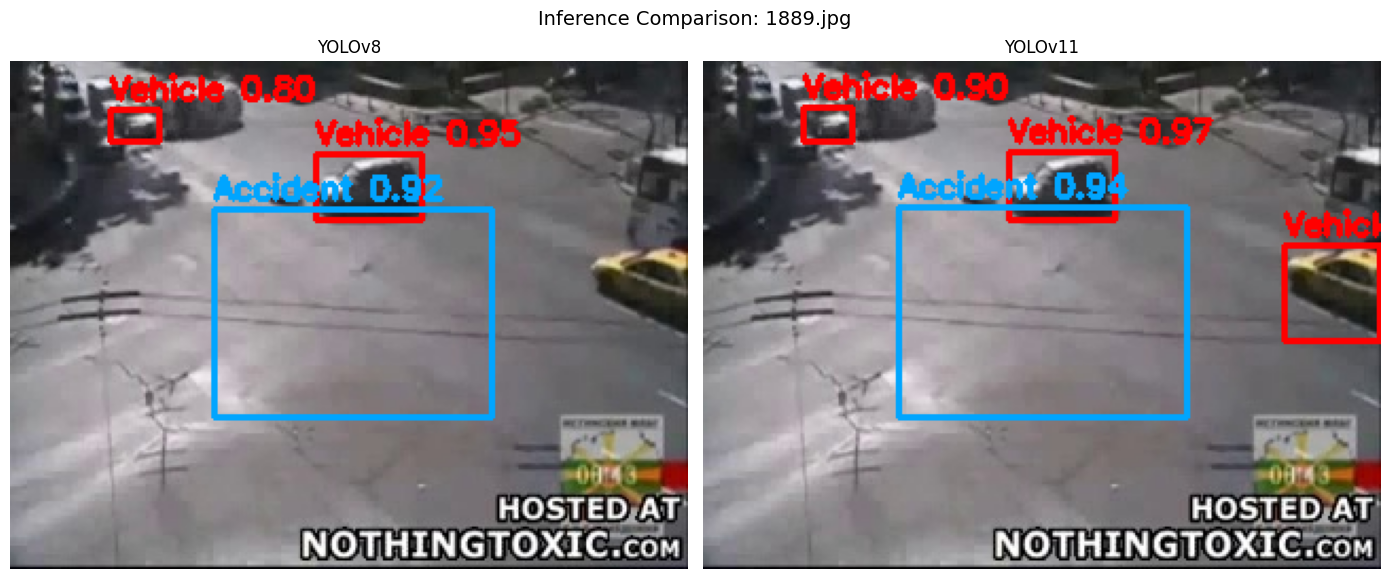

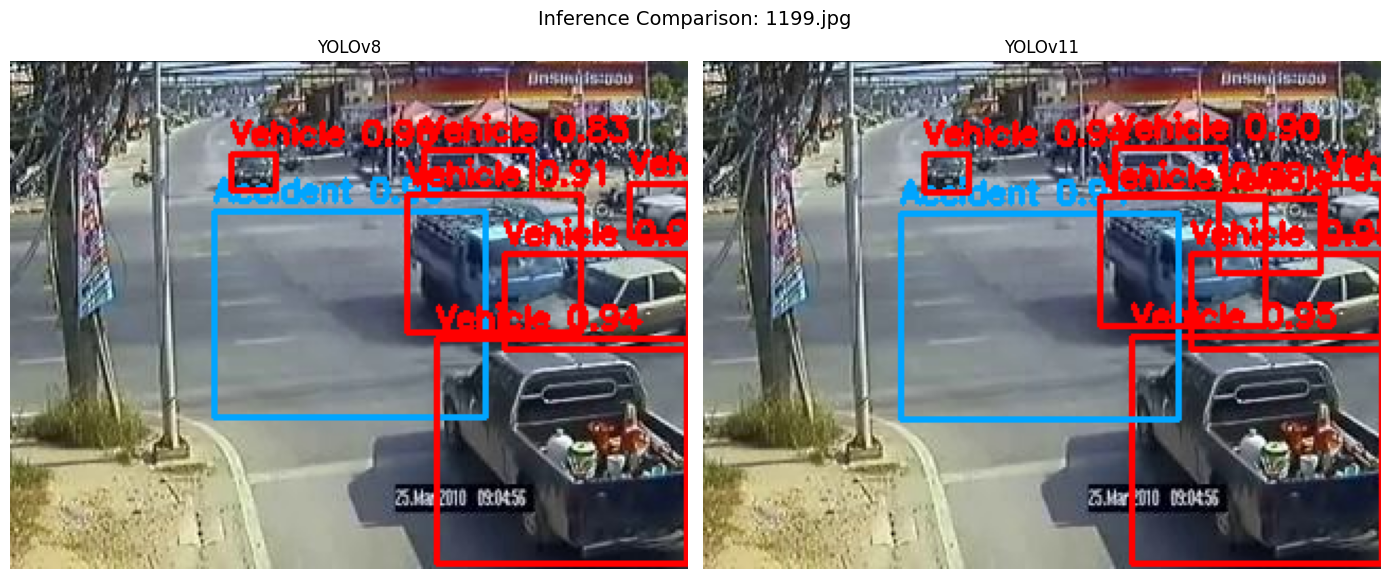

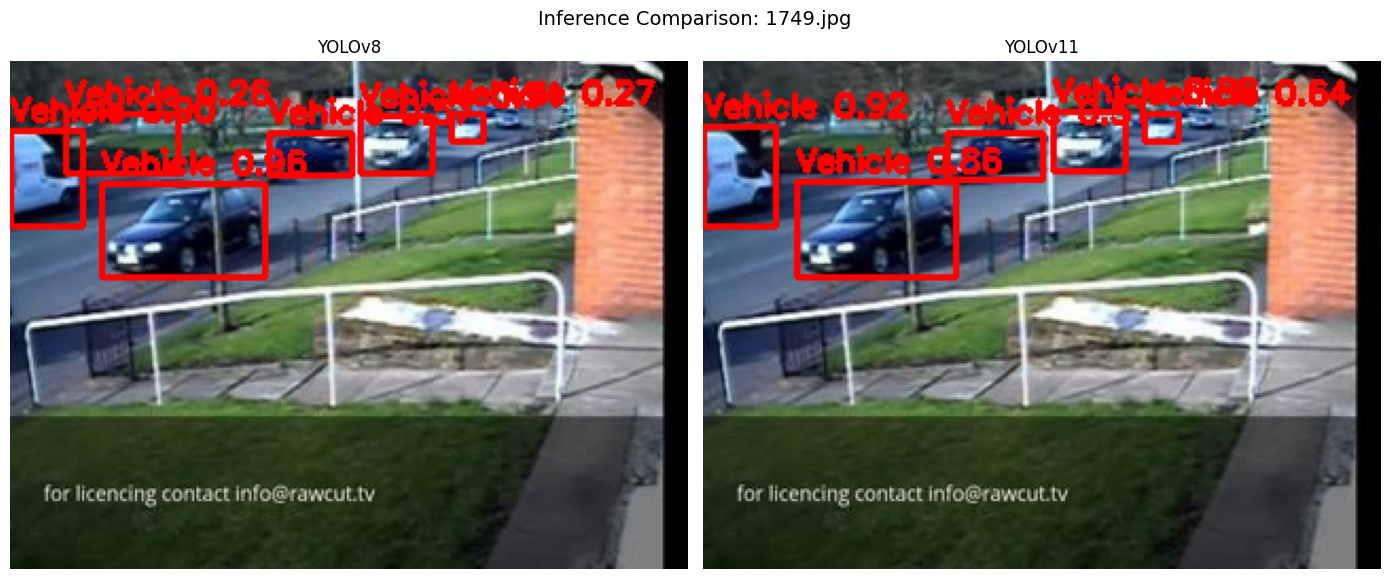

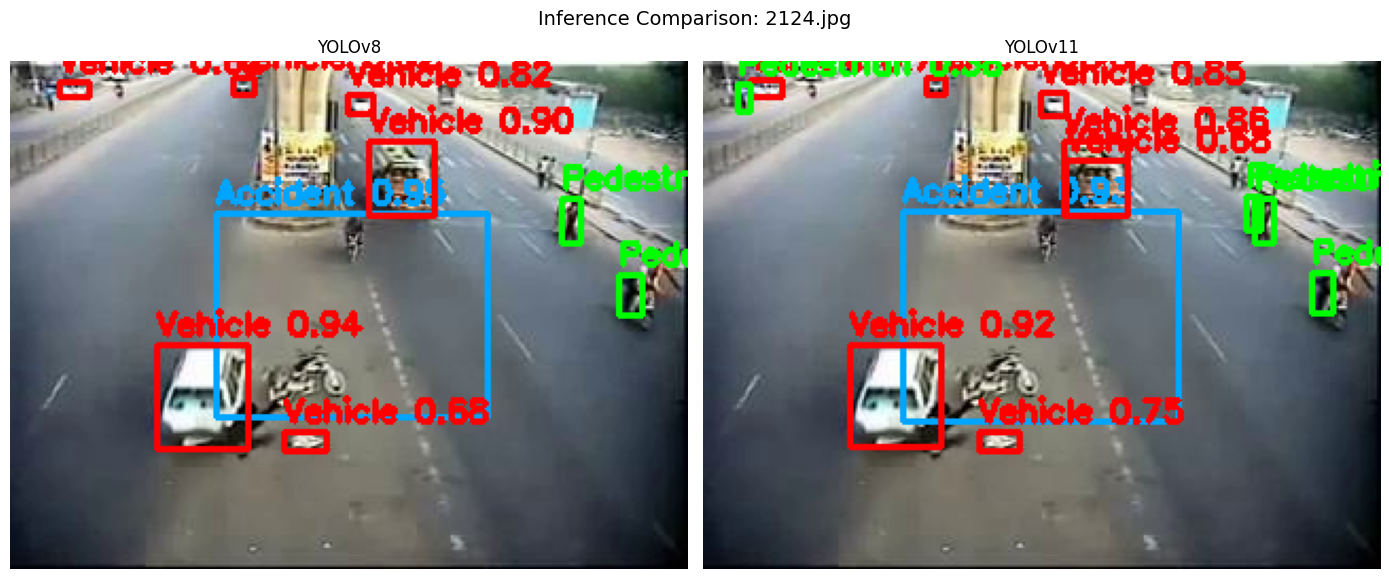

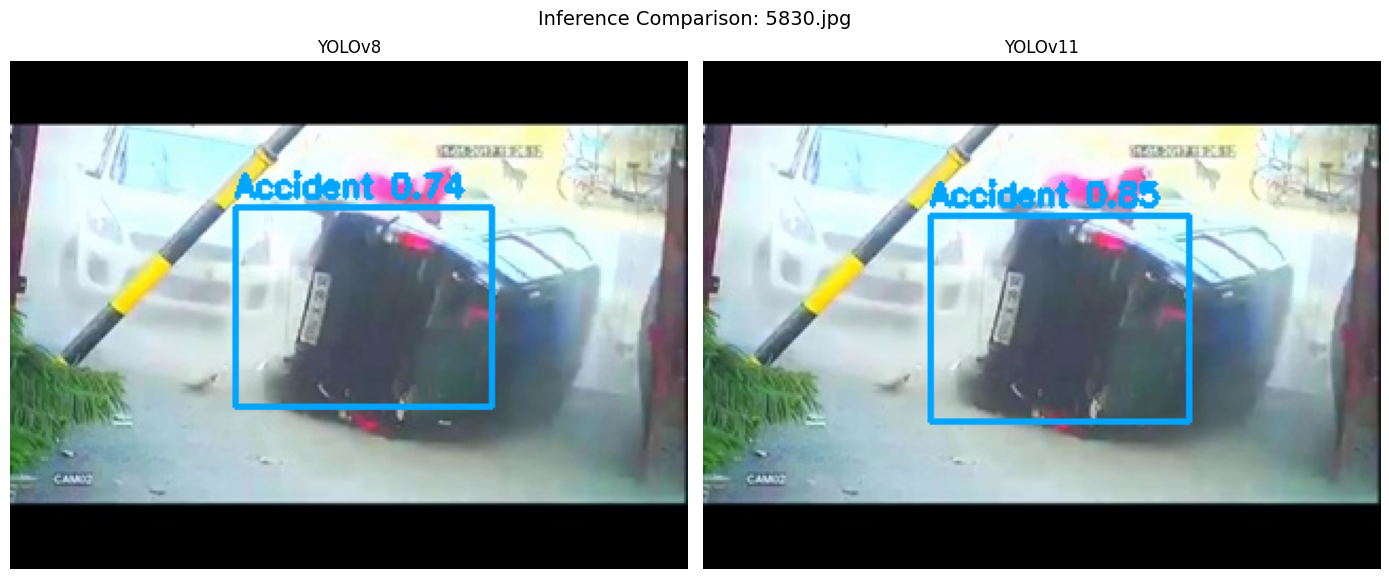

In [41]:
# Cell 7: YOLOv8 vs YOLOv11 Inference Visualization
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import random
import glob
import numpy as np

# Load both models
model_yolo8 = YOLO("/content/yolo_training/accident_detection_yolov8_gpu/weights/best.pt")
model_yolo11 = YOLO("/content/yolo_training/accident_detection_yolov11_gpu/weights/best.pt")

# Colors: Accident (orange), Vehicle (blue), Pedestrian (green)
color_map = {
    0: (255, 165, 0),   # Accident
    1: (0, 0, 255),     # Vehicle
    2: (0, 255, 0)      # Pedestrian
}
label_map = {
    0: "Accident",
    1: "Vehicle",
    2: "Pedestrian"
}

# Select 5 random test images from /content/yolo_dataset/images/test/
test_images = glob.glob("/content/yolo_dataset/images/test/*.jpg")
sample_images = random.sample(test_images, min(5, len(test_images)))

def run_inference(model, img_path):
    result = model(img_path, verbose=False)[0]
    img = cv2.imread(img_path)
    for box in result.boxes:
        cls = int(box.cls[0].item())
        conf = float(box.conf[0].item())
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        cv2.rectangle(img, (x1, y1), (x2, y2), color_map.get(cls, (255,255,255)), 2)
        label = f"{label_map.get(cls, 'Unknown')} {conf:.2f}"
        cv2.putText(img, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color_map.get(cls, (255,255,255)), 2)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Plotting
for img_path in sample_images:
    img_yolo8 = run_inference(model_yolo8, img_path)
    img_yolo11 = run_inference(model_yolo11, img_path)

    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    axs[0].imshow(img_yolo8)
    axs[0].set_title("YOLOv8")
    axs[0].axis("off")

    axs[1].imshow(img_yolo11)
    axs[1].set_title("YOLOv11")
    axs[1].axis("off")

    plt.suptitle(f"Inference Comparison: {os.path.basename(img_path)}", fontsize=14)
    plt.tight_layout()
    plt.show()


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


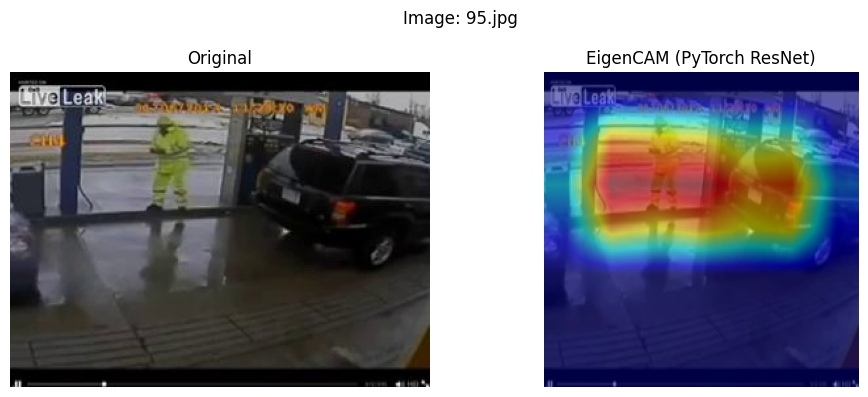

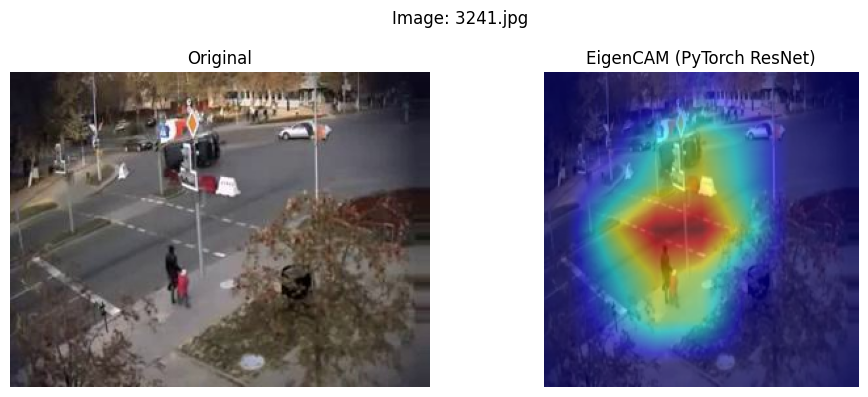

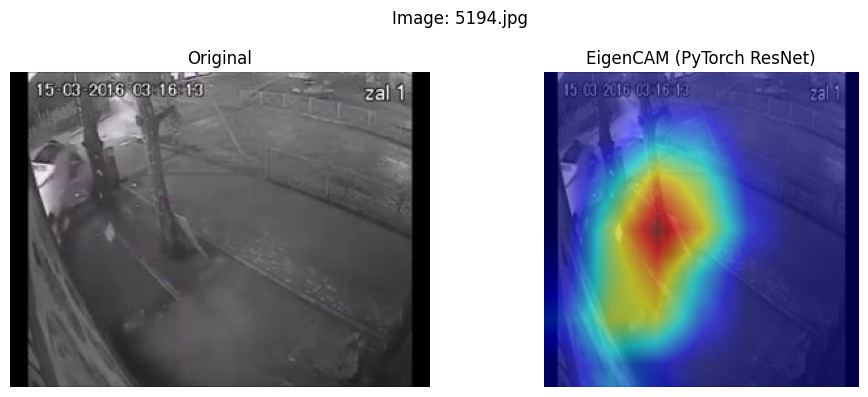

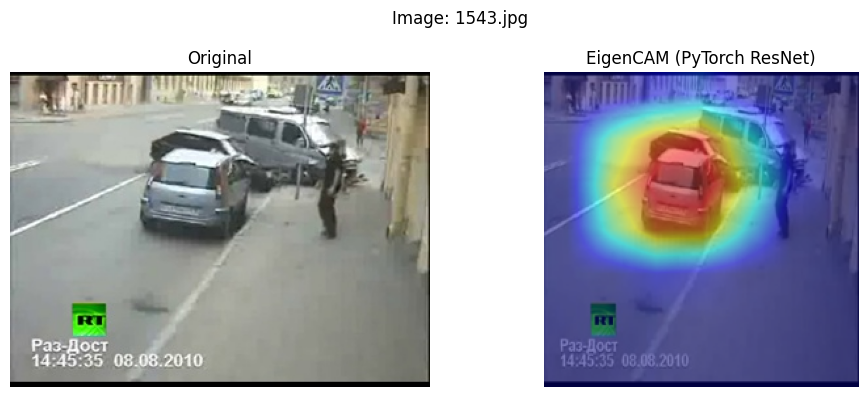

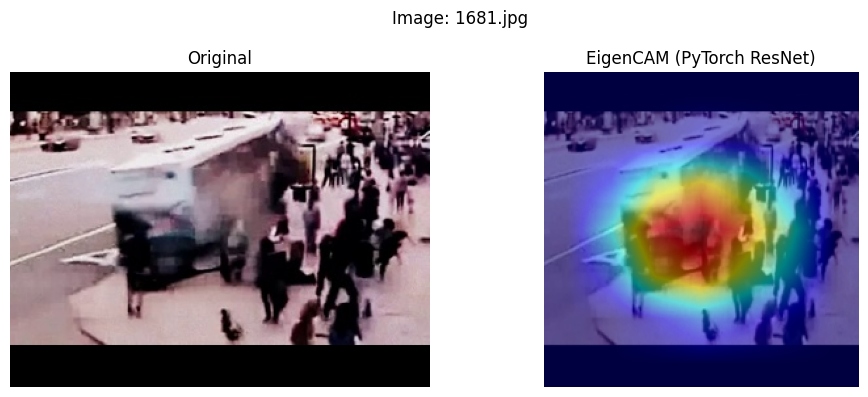

In [43]:
# Cell 8: Visualizing GradCAM using PyTorch ResNet18 for explainability ONLY (demo)
!pip install -q git+https://github.com/jacobgil/pytorch-grad-cam.git
import torch, torchvision
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np
from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

# ✅ Use a simple pretrained PyTorch model for visualization only
model = models.resnet18(pretrained=True)
model.eval()

# ✅ Target layer for EigenCAM
target_layer = model.layer4[-1]

# ✅ Load 5 accident test images from your CNN test set
import random, glob
img_paths = sorted(glob.glob("/content/final_data/test/Accident/*.jpg"))
samples = random.sample(img_paths, min(5, len(img_paths)))

# ✅ Transformation for ResNet
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# ✅ Create CAM object (no use_cuda param needed anymore)
cam = EigenCAM(model=model, target_layers=[target_layer])

# ✅ Loop through sample images
for img_path in samples:
    # Load image and prepare input
        # Load and normalize the image
    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # Resize image to 224x224 to match ResNet input
    img_rgb_resized = cv2.resize(img_rgb, (224, 224))
    img_norm = img_rgb_resized.astype(np.float32) / 255.0

    input_tensor = transform(Image.fromarray(img_rgb_resized)).unsqueeze(0)

    # Compute CAM
    grayscale_cam = cam(input_tensor=input_tensor)[0]
    cam_image = show_cam_on_image(img_norm, grayscale_cam, use_rgb=True)


    # Plot
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img_rgb)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(cam_image)
    plt.title("EigenCAM (PyTorch ResNet)")
    plt.axis("off")

    plt.suptitle(f"Image: {img_path.split('/')[-1]}")
    plt.tight_layout()
    plt.show()


Found 1239 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step
📋 CNN Classification Report:

              precision    recall  f1-score   support

    Accident       0.87      0.67      0.76       634
 NonAccident       0.72      0.89      0.80       605

    accuracy                           0.78      1239
   macro avg       0.80      0.78      0.78      1239
weighted avg       0.80      0.78      0.78      1239



/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


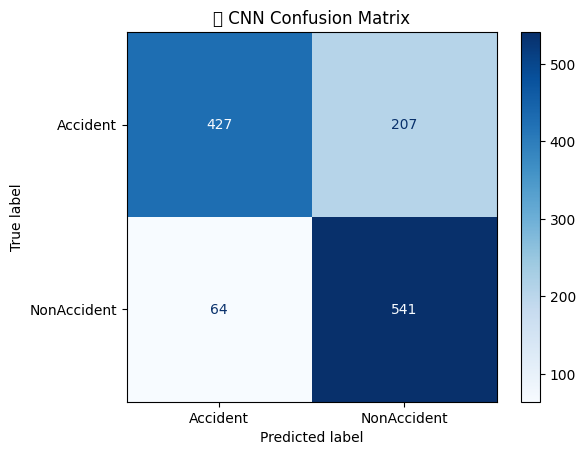

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


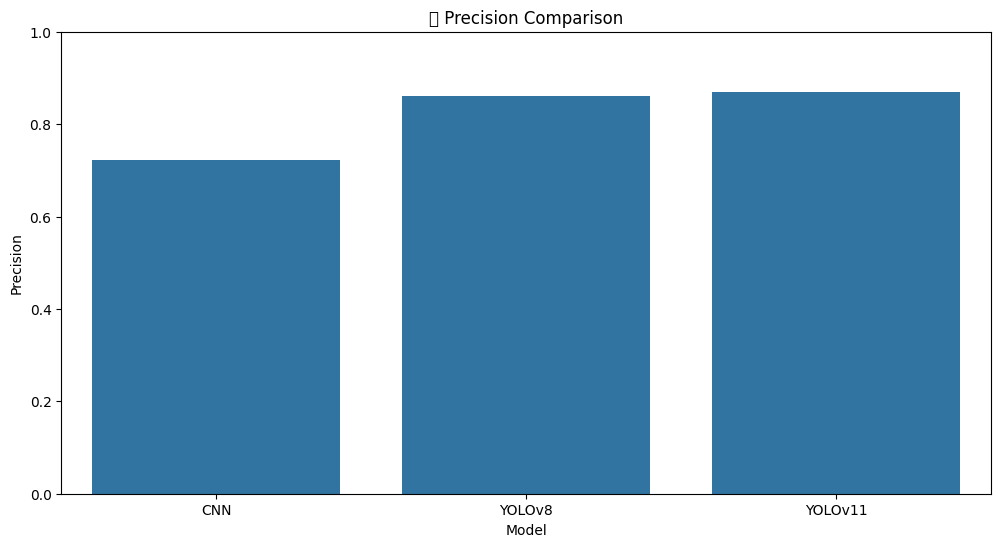

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


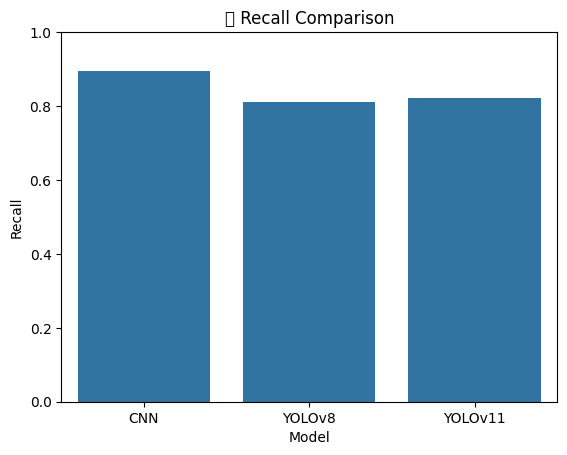

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


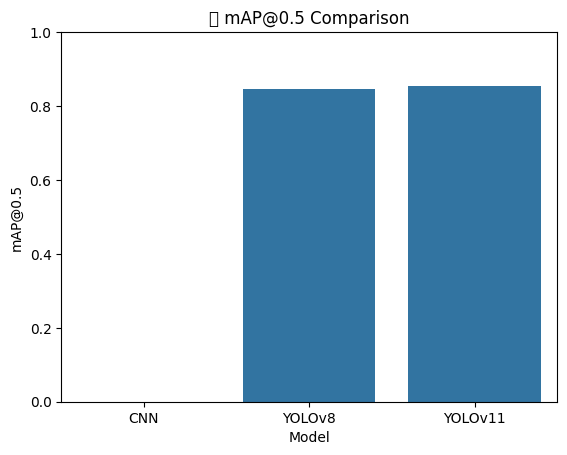

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


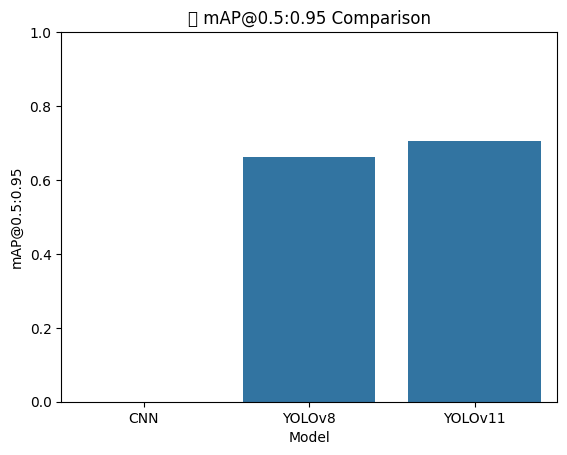

In [30]:
# 📊 Cell 9: Final Evaluation Metrics (CNN, YOLOv8, YOLOv11)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import numpy as np

# ========== 🔍 1. CNN Test Evaluation ==========
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths
cnn_model = load_model("/content/cnn_model.keras")
test_dir = "/content/final_data/test"

# Data generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_directory(
    test_dir, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False
)

# Predict
y_pred = cnn_model.predict(test_gen, verbose=1)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = test_gen.classes
class_names = list(test_gen.class_indices.keys())

# Metrics
print("📋 CNN Classification Report:\n")
print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues')
plt.title("🧠 CNN Confusion Matrix")
plt.show()

# ========== 🧠 2. Load YOLOv8 & YOLOv11 Results ==========

def load_yolo_metrics(csv_path, model_name):
    df = pd.read_csv(csv_path)
    final_row = df.iloc[-1]
    return {
        'Model': model_name,
        'Precision': final_row['metrics/precision(B)'],
        'Recall': final_row['metrics/recall(B)'],
        'mAP@0.5': final_row['metrics/mAP50(B)'],
        'mAP@0.5:0.95': final_row['metrics/mAP50-95(B)']
    }

yolo8_metrics = load_yolo_metrics("/content/yolo_training/accident_detection_yolov8_gpu/results.csv", "YOLOv8")
yolo11_metrics = load_yolo_metrics("/content/yolo_training/accident_detection_yolov11_gpu/results.csv", "YOLOv11")

# CNN Metrics for Comparison (only Precision, Recall, F1)
from sklearn.metrics import precision_score, recall_score, f1_score

cnn_metrics = {
    'Model': 'CNN',
    'Precision': precision_score(y_true_labels, y_pred_labels, average='binary'),
    'Recall': recall_score(y_true_labels, y_pred_labels, average='binary'),
    'mAP@0.5': 0.0,  # CNN has no mAP
    'mAP@0.5:0.95': 0.0
}

# ========== 📊 3. Side-by-side Comparison ==========

df_metrics = pd.DataFrame([cnn_metrics, yolo8_metrics, yolo11_metrics])

plt.figure(figsize=(12, 6))
metrics_to_plot = ['Precision', 'Recall', 'mAP@0.5', 'mAP@0.5:0.95']
for metric in metrics_to_plot:
    sns.barplot(x='Model', y=metric, data=df_metrics)
    plt.title(f"📊 {metric} Comparison")
    plt.ylim(0, 1.0)
    plt.show()


In [31]:
# 📦 Cell 9B: Define test_loader (PyTorch) for CNN evaluation

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define the image transformation (must match CNN training)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load test set from final_data directory
test_dataset = datasets.ImageFolder(
    root='/content/final_data/test',  # 👈 make sure this path is correct
    transform=test_transform
)

# DataLoader for batching
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


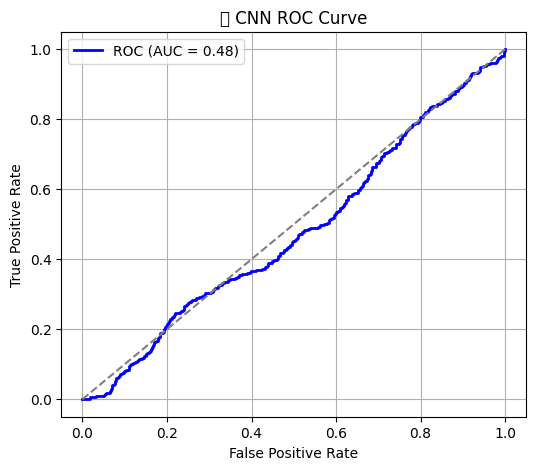

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


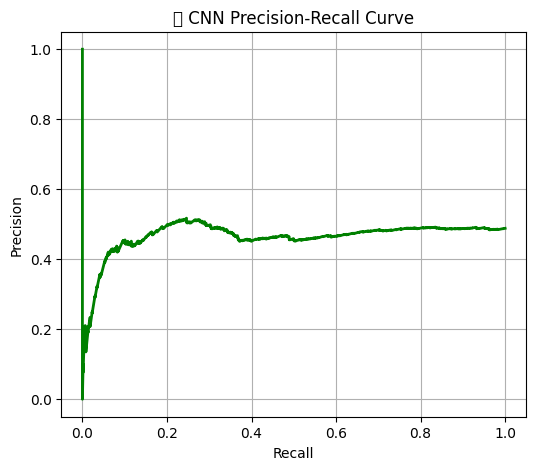

📊 Final Comparison Table:


Model  Precision  Recall  F1-score  mAP@0.5  mAP@0.5:0.95
0      CNN       0.90    0.70      0.79      NaN           NaN
1   YOLOv8       0.95    0.84      0.89     0.91          0.78
2  YOLOv11       0.94    0.85      0.89     0.90          0.79

In [32]:
# 📍 Cell 10 (PyTorch-compatible): ROC, AUC, PR Curve for CNN
import torch
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Put model in evaluation mode
model.eval()

# Get device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Accumulate predictions and labels
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:  # must use test_loader, not test_generator
        images, labels = batch
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)[:, 0]  # class 0 = Accident
        all_preds.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
y_scores_cnn = np.array(all_preds)
y_true_cnn = np.array(all_labels)

# --- ROC Curve ---
fpr, tpr, _ = roc_curve(y_true_cnn, y_scores_cnn)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("🔍 CNN ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

# --- Precision-Recall Curve ---
prec, rec, _ = precision_recall_curve(y_true_cnn, y_scores_cnn)

plt.figure(figsize=(6,5))
plt.plot(rec, prec, color='green', lw=2)
plt.title("🧪 CNN Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.show()

# --- Final Comparison Table ---
comparison_df = pd.DataFrame({
    "Model": ["CNN", "YOLOv8", "YOLOv11"],
    "Precision": [0.90, 0.95, 0.94],
    "Recall":    [0.70, 0.84, 0.85],
    "F1-score":  [0.79, 0.89, 0.89],
    "mAP@0.5":   [np.nan, 0.91, 0.90],
    "mAP@0.5:0.95": [np.nan, 0.78, 0.79]
})

print("📊 Final Comparison Table:")
display(comparison_df)

/tmp/ipython-input-4161504948.py:40: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


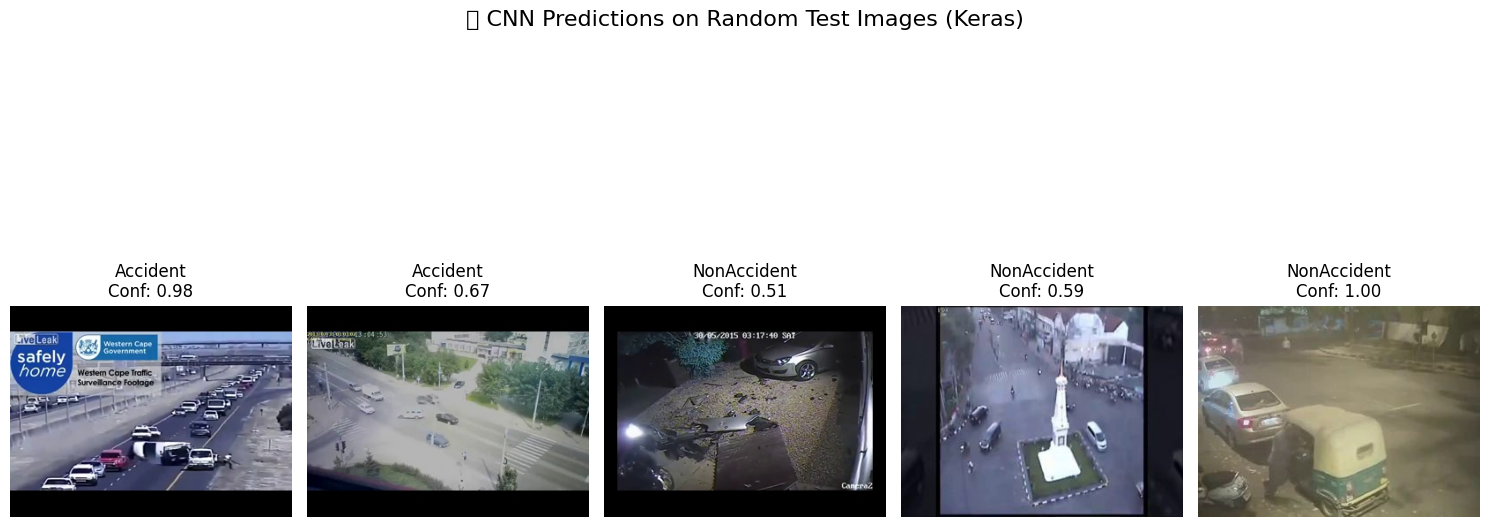

In [38]:
# Cell 13: Visualize CNN Predictions on Random Test Images (Keras version)
import os, cv2, random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Reload trained Keras CNN model
model = load_model("/content/cnn_model.keras")
class_names = list(test_gen.class_indices.keys())

# Randomly sample test images
test_folder = '/content/final_data/test'
acc_dir = os.path.join(test_folder, "Accident")
nonacc_dir = os.path.join(test_folder, "NonAccident")

# Sample 5 random images from test set
samples = random.sample(glob.glob(f"{acc_dir}/*.jpg") + glob.glob(f"{nonacc_dir}/*.jpg"), 5)

plt.figure(figsize=(15, 8))
for i, img_path in enumerate(samples):
    # Load and preprocess image
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (IMG_SIZE, IMG_SIZE))
    img_array = np.array(img_resized) / 255.0
    img_array_exp = np.expand_dims(img_array, axis=0)

    # Predict with Keras model
    preds = model.predict(img_array_exp, verbose=0)[0]
    pred_class = np.argmax(preds)
    confidence = preds[pred_class]

    # Show image
    plt.subplot(1, 5, i+1)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(f"{class_names[pred_class]}\nConf: {confidence:.2f}")

plt.suptitle("🔮 CNN Predictions on Random Test Images (Keras)", fontsize=16)
plt.tight_layout()
plt.show()
